# Imports

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv("../../data/titanic.csv")

# Teil 1: Visualisierung

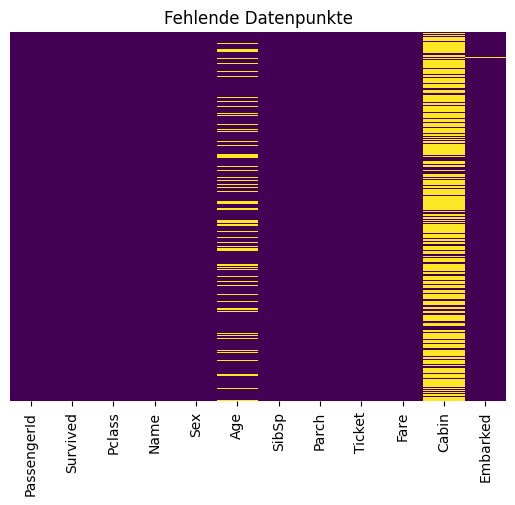

In [41]:
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Fehlende Datenpunkte");

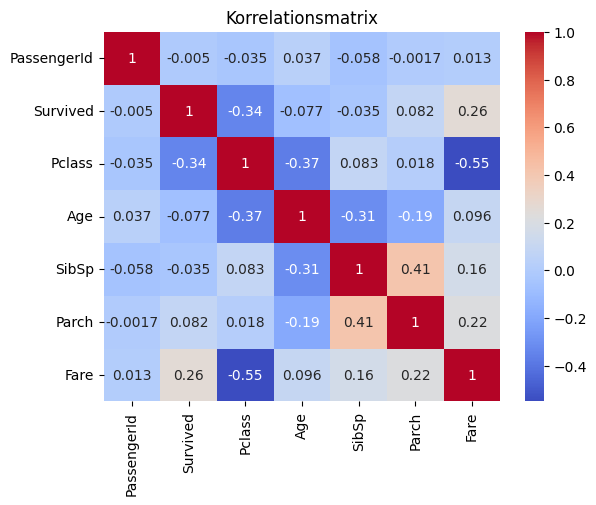

In [42]:
numeric_df = df.select_dtypes(include=["number"])

sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Korrelationsmatrix");

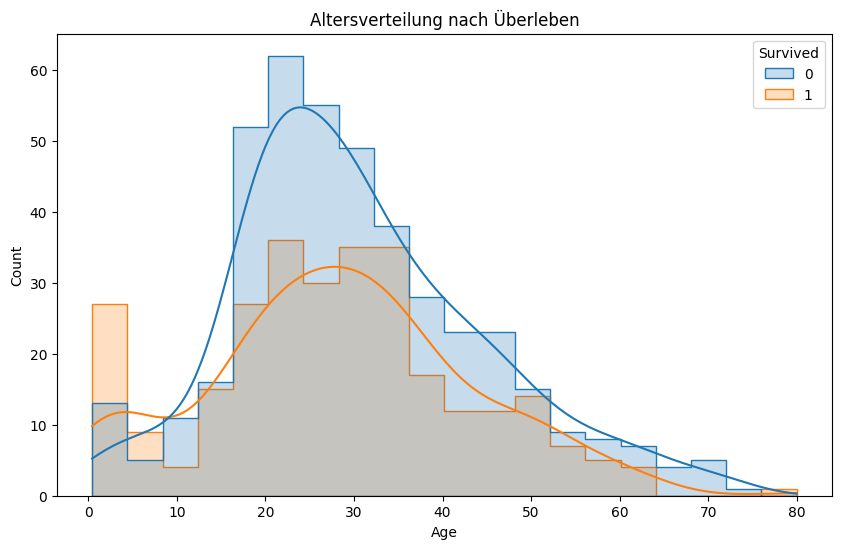

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Age", hue="Survived", kde=True, element="step")
plt.title("Altersverteilung nach Überleben");

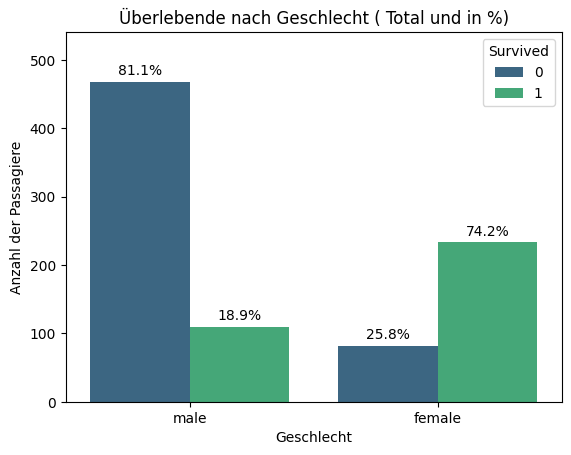

In [44]:
order_sex = ["male", "female"]
ax = sns.countplot(data=df, x="Sex", hue="Survived", order=order_sex, palette="viridis")

totals = df["Sex"].value_counts().reindex(order_sex)

for container in ax.containers:
    labels = []
    for bar, total_count in zip(container, totals):
        height = bar.get_height()
        if np.isnan(height):
            percentage = 0
        else:
            percentage = (height / total_count) * 100
        labels.append(f"{percentage:.1f}%")
    ax.bar_label(container, labels=labels, label_type="edge", padding=3)

plt.title("Überlebende nach Geschlecht ( Total und in %)")
plt.xlabel("Geschlecht")
plt.ylabel("Anzahl der Passagiere")
plt.legend(title="Survived")
plt.ylim(0, plt.ylim()[1] * 1.1);

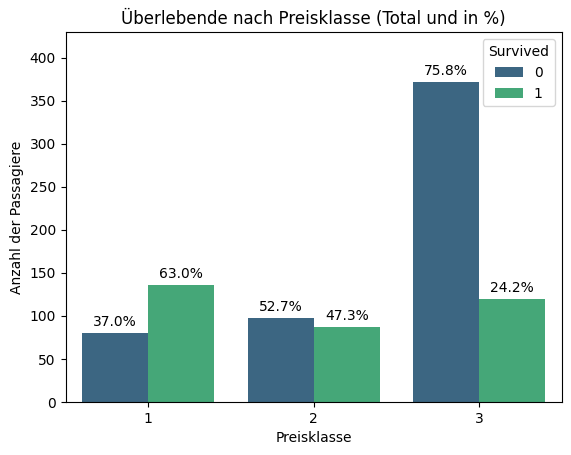

In [62]:
order_pclass = [1, 2, 3]

ax = sns.countplot(data=df, x="Pclass", hue="Survived", order=order_pclass, palette="viridis")

totals = df["Pclass"].value_counts().reindex(order_pclass)

for container in ax.containers:
    labels = []
    for bar, total_count in zip(container, totals):
        height = bar.get_height()
        if np.isnan(height):
            percentage = 0
        else:
            percentage = (height / total_count) * 100
        labels.append(f"{percentage:.1f}%")
    ax.bar_label(container, labels=labels, label_type="edge", padding=3)

plt.title("Überlebende nach Preisklasse (Total und in %)")
plt.xlabel("Preisklasse")
plt.ylabel("Anzahl der Passagiere")
plt.legend(title="Survived")
plt.ylim(0, plt.ylim()[1] * 1.1);

# Teil 2: Machine Learning

**Vorbereitung der Daten:**

In [5]:
# Sex":
# In 0/1 umwandeln
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

# "Embarked":
# fehlende Werte auffüllen (mit dem häufigsten Wert)
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
# in Zahlen umwandeln
le = LabelEncoder()
df["Embarked"] = le.fit_transform(df["Embarked"])

# "Age": 
# auffülen mit Median-Alter
df["Age"] = df["Age"].fillna(df["Age"].median())

Features festlegen:

In [6]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
x = df[features]
y = df["Survived"]

Spliten der Daten:

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

Training des Models:

In [8]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Testen des Models

In [14]:
y_pred = model.predict(x_test)

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Mcc: {mcc:.4f}")

Mcc: 0.6249


**Optimieren der Hyperparameter:**

Auswahl der Testparameter:

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 300],        # anzahl Bäume
    "max_depth": [None, 5, 10, 15],         # max Tiefe eines Baums
    "min_samples_split": [2, 5, 10],        # min Samples pro Split
    "min_samples_leaf": [1, 2, 4]           # min Samples pro Blatt
}

Suche nach optimalen Parametern:

In [ ]:
mcc_scorer = make_scorer(matthews_corrcoef)

grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=1, 
    scoring=mcc_scorer
)

grid_search.fit(x_train, y_train)

print(f"Beste Parameter: {grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Beste Parameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Bester MCC Score: 0.6134


Test mit neuen Hyperparametern:

In [17]:
best_model = grid_search.best_estimator_

y_pred_tuned = best_model.predict(x_test)

mcc_tuned = matthews_corrcoef(y_test, y_pred_tuned)

# Vergleich zum Basis-Modell (falls Block 5 ausgeführt wurde)
print(f"\nVergleich zur Basis-mcc: {mcc:.4f} vs {mcc_tuned:.4f}")


Vergleich zur Basis-mcc: 0.6249 vs 0.6795
